In [10]:
# Imports for RD Shapes dataset
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import trimesh
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix

In [11]:
#Loading and displaying first few rows
csv_path = './RandomShapes3D/dataset.csv' 
data = pd.read_csv(csv_path)

print(data.columns)
data.head()


Index(['filename', 'shape', 'operation', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
       'h', 'i', 'j', 'k', 'l', 'hue', 'sat', 'val', 'rot_x', 'rot_y', 'rot_z',
       'pos_x', 'pos_y', 'pos_z'],
      dtype='object')


,filename,shape,operation,a,b,c,d,e,f,g,...,l,hue,sat,val,rot_x,rot_y,rot_z,pos_x,pos_y,pos_z
0,shape_0.png,0,0,2.662669,1.249511,0.000000,0.0,0.000000,0,0.000000,...,0,0.052947,1,1,32.44447,251.17800,319.12660,0.586812,0.586812,0.586812
1,shape_1.png,15,0,1.622726,0.667528,1.432613,0.0,0.000000,0,0.000000,...,0,0.465424,1,1,339.13980,84.60025,328.84890,0.219629,0.219629,0.219629
2,shape_2.png,3,0,2.587109,0.607928,0.000000,0.0,0.000000,0,0.000000,...,0,0.282066,1,1,11.06687,143.49090,87.67636,0.204211,0.204211,0.204211
3,shape_3.png,11,0,0.000000,2.292835,0.000000,0.0,-0.767775,0,1.560978,...,0,0.366291,1,1,310.67760,318.45330,272.23350,0.271552,0.271552,0.271552
4,shape_4.png,0,0,3.259933,2.363546,0.000000,0.0,0.000000,0,0.000000,...,0,0.443555,1,1,33.79867,169.68650,40.63982,-0.933827,-0.933827,-0.933827


In [4]:
class RandomShapesDataset(Dataset):
    def __init__(self, root_dir, csv_file='dataset.csv', augment=False, image_size=(224, 224)):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.augment = augment
        self.image_size = image_size
        
        # Load the CSV file
        csv_path = os.path.join(root_dir, csv_file)
        self.data = pd.read_csv(csv_path)
        
        # Use the 'filename' and 'shape' columns
        self.files = self.data['filename'].tolist()
        self.labels = self.data['shape'].tolist()

        # Get unique classes
        self.classes = sorted(list(set(self.labels)))
        
        # Define image transformations
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming grayscale images; adjust if RGB
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        label = self.labels[idx]
        
        # Load the image
        img_path = os.path.join(self.root_dir, 'images', file_name)
        image = Image.open(img_path).convert('L')  # Convert to grayscale if needed
        
        # Apply transformations
        image = self.transform(image)
        
        # Convert label to index
        label_index = self.classes.index(label)
        
        return image, label_index

In [12]:
# Define the root directory and CSV file path
root_dir = './RandomShapes3D'  # Replace with your actual path
csv_file = 'dataset.csv'

# Instantiate the dataset
random_shapes_dataset = RandomShapesDataset(root_dir=root_dir, csv_file=csv_file, augment=True)

# Create DataLoader
random_shapes_loader = DataLoader(random_shapes_dataset, batch_size=16, shuffle=True)

# Example: Iterating through the DataLoader
for batch_idx, (images, labels) in enumerate(random_shapes_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Images Shape: {images.shape}")
    print(f"Labels: {labels}")
    break  # Remove this if you want to iterate over the entire dataset


Batch 1
Images Shape: torch.Size([16, 1, 224, 224])
Labels: tensor([ 6, 10,  5,  2,  0, 14, 13, 11,  0, 15,  7, 13, 12,  3, 15,  0])


In [13]:
# Example: Iterating through the DataLoader
for batch_idx, (voxel_grids, labels) in enumerate(random_shapes_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Voxel Grids Shape: {voxel_grids.shape}")
    print(f"Labels: {labels}")
    break  


Batch 1
Voxel Grids Shape: torch.Size([16, 1, 224, 224])
Labels: tensor([ 9,  3,  6,  7,  8, 10,  2, 10, 10,  1, 13,  4,  4, 11,  6,  4])


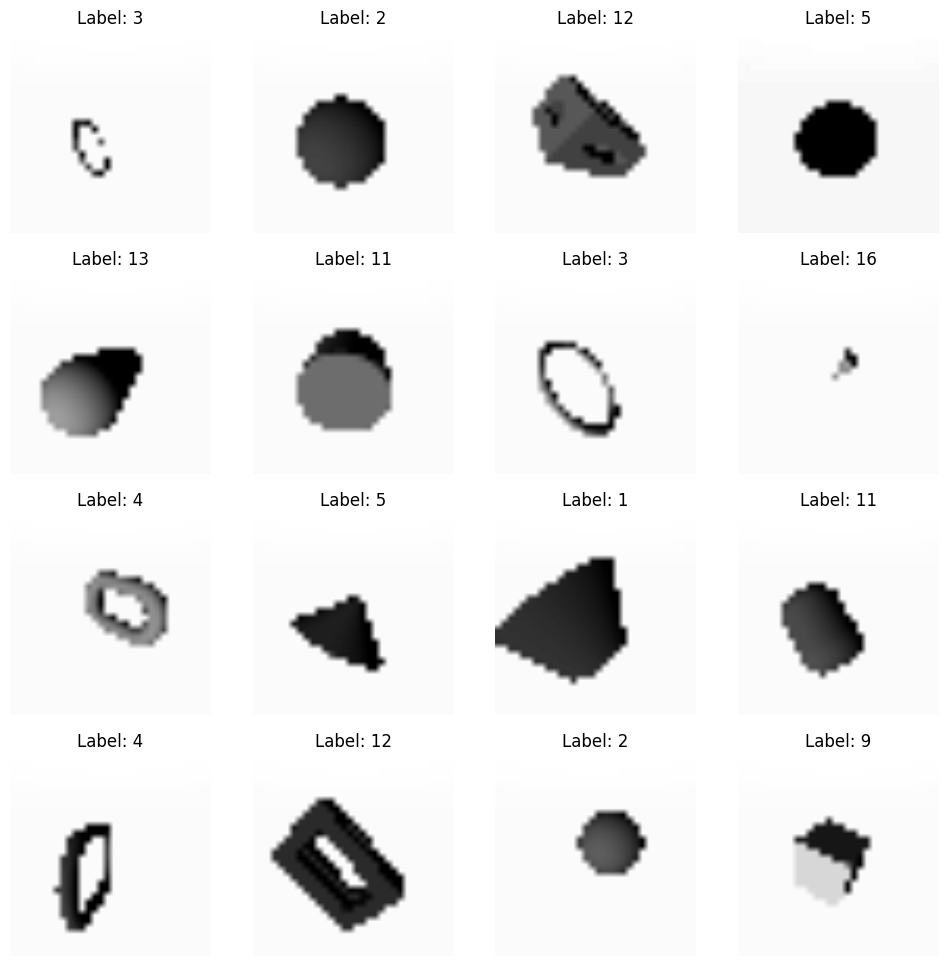

In [14]:
# Visualize a batch of images
images, labels = next(iter(random_shapes_loader))

plt.figure(figsize=(12, 12))
for i in range(16):  # Adjust based on the batch size or number of images to show
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0).numpy(), cmap='gray')  # Adjust cmap if images are RGB
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()


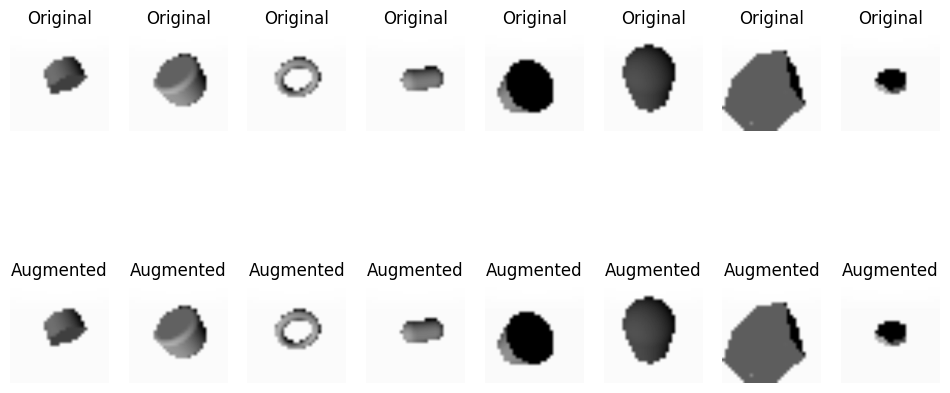

In [15]:
# Visualize augmented data
random_shapes_dataset_no_aug = RandomShapesDataset(root_dir=root_dir, csv_file=csv_file, augment=False)
random_shapes_dataset_with_aug = RandomShapesDataset(root_dir=root_dir, csv_file=csv_file, augment=True)

# Display original vs augmented
plt.figure(figsize=(12, 6))
for i in range(8):  # Show 8 images, adjust as needed
    original_img, _ = random_shapes_dataset_no_aug[i]
    augmented_img, _ = random_shapes_dataset_with_aug[i]

    plt.subplot(2, 8, i+1)
    plt.imshow(original_img.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 8, i+9)
    plt.imshow(augmented_img.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title('Augmented')
    plt.axis('off')

plt.show()


In [16]:
# Define a simple CNN model for image classification
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Check if CUDA (GPU) is available, otherwise use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
num_classes = len(random_shapes_dataset.classes)
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [17]:
# Initialize the model, loss function, and optimizer
num_classes = len(random_shapes_dataset.classes)
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [19]:
# FGSM attack for images
def fgsm_attack(images, labels, model, criterion, epsilon=0.01):
    model.eval()
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images

# Example usage of FGSM attack in the training loop
def train_model_with_fgsm_attack(model, dataloader, optimizer, criterion, device, epsilon=0.01):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Apply FGSM attack
        perturbed_images = fgsm_attack(images, labels, model, criterion, epsilon)

        optimizer.zero_grad()
        outputs = model(perturbed_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [20]:
# Main training loop
num_epochs = 5
best_val_acc = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train with FGSM attack
    train_loss, train_acc = train_model_with_fgsm_attack(model, random_shapes_loader, optimizer, criterion, device, epsilon=0.01)
    
    # Evaluate without attack
    val_loss, val_acc = evaluate_model(model, random_shapes_loader, criterion, device)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved!")

print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Epoch 1/5
Train Loss: 2.9687, Train Acc: 6.80%, Val Loss: 2.8279, Val Acc: 9.30%
Model saved!
Epoch 2/5
Train Loss: 2.6213, Train Acc: 15.30%, Val Loss: 2.5207, Val Acc: 22.20%
Model saved!
Epoch 3/5
Train Loss: 2.3531, Train Acc: 21.70%, Val Loss: 2.3152, Val Acc: 26.20%
Model saved!
Epoch 4/5
Train Loss: 2.1054, Train Acc: 31.10%, Val Loss: 1.8848, Val Acc: 39.40%
Model saved!
Epoch 5/5
Train Loss: 1.8815, Train Acc: 38.40%, Val Loss: 1.6613, Val Acc: 43.60%
Model saved!
Best Validation Accuracy: 43.60%


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

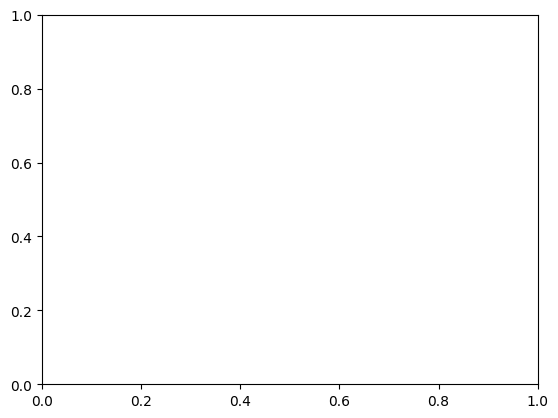

In [21]:
# Visualize Training and Validation Metrics
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Confusion Matrix (if applicable)


# Example confusion matrix
labels_pred = [0, 1, 2]  # Replace with model predictions
labels_true = [0, 1, 2]  # Replace with ground truth
cm = confusion_matrix(labels_true, labels_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
